# Implicit feedback recommender system
- https://github.com/benfred/implicit
- https://www.benfrederickson.com/matrix-factorization/
- https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
- https://kojinoshiba.com/recsys-cold-start/

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

# Data Exploration

In [2]:
# Read csv files
df = pd.read_csv('retail.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df['Cancellation'] = list(
    map(lambda x: x.startswith('C'), df['InvoiceNo'])) 

In [5]:
# Get df_events and correctly encode the variables
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.astype({'InvoiceNo': object, 'StockCode': object, 'CustomerID': object})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False


In [6]:
# Describe dataset
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.0,541909,541909
unique,25900,4070,4223,NaN,23260,NaN,4372.0,38,2
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,17841.0,United Kingdom,False
freq,1114,2313,2369,NaN,1114,NaN,7983.0,495478,532621
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,NaN,NaN,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,NaN,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,NaN,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,NaN,NaN,NaN


In [7]:
#create the dataframe with new costumers
cancellations = df.loc[df['Cancellation'] == True]
cancellations

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,True
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,True
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,True
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,True


In [8]:
#create the dataframe with new costumers
new_customers = df.loc[pd.isnull(df.CustomerID) == True]
new_customers

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,False
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,False
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,False
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,False
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,False
...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,False
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,False
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,False
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom,False


In [9]:
# Missing values
df.isna().sum()  # transactionid is only present when the event is transaction

InvoiceNo            0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
Cancellation         0
dtype: int64

In [15]:
#removing the offers or gifts
df=df.loc[df.UnitPrice> 0]

In [17]:
#Create the new DB wo Cancellations and new Customers 
df = df.loc[(pd.isnull(df.CustomerID) == False) & (df['Cancellation'] == False)]
#df = df.loc[pd.isnull(df['CustomerID'] == False)]
#df = df.loc[pd.isnull(df['Cancellation'] == False)]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,False
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,False
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,False
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,False


In [18]:
# Missing values
df.isna().sum()  # transactionid is only present when the event is transaction

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
Cancellation    0
dtype: int64

In [299]:
# How many weeks does the dataset has?
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 373 days, corresponding to 53 weeks.


In [19]:

cleaned_df = df[['StockCode', 'Quantity', 'CustomerID']] # Get rid of unnecessary info


In [20]:
cleaned_df

,StockCode,Quantity,CustomerID
0,85123A,6,17850
1,71053,6,17850
2,84406B,8,17850
3,84029G,6,17850
4,84029E,6,17850
...,...,...,...
541904,22613,12,12680
541905,22899,6,12680
541906,23254,4,12680
541907,23255,4,12680


In [21]:
#will give unique pairs of customer and item_id
grouped_cleaned = cleaned_df.groupby(['CustomerID', 'StockCode']).sum().reset_index() # Group together


In [33]:
grouped_cleaned

,CustomerID,StockCode,Quantity
0,12346.0,23166,74215
1,12347.0,16008,24
2,12347.0,17021,36
3,12347.0,20665,6
4,12347.0,20719,40
...,...,...,...
266787,18287.0,84920,4
266788,18287.0,85039A,96
266789,18287.0,85039B,120
266790,18287.0,85040A,48


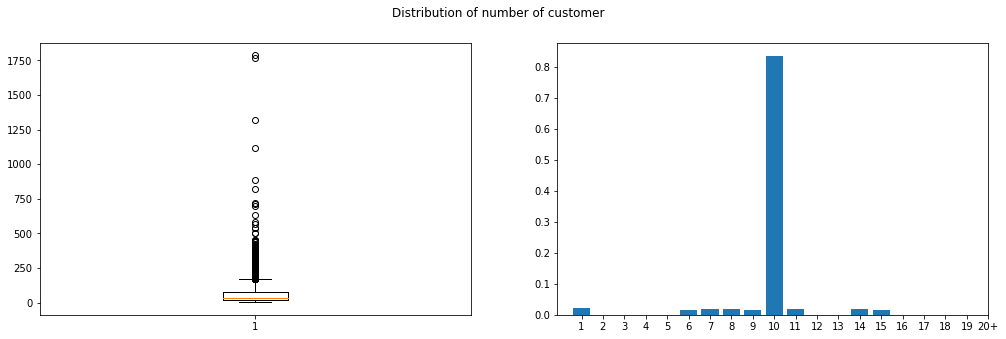

88.98% of customer have more than 7 event!


In [38]:
# Distribution of number of interactions
data1 = grouped_cleaned['CustomerID'].value_counts()  # count of events per customer
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  # count of counts of events per customer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,21)))
ax2.set_xticklabels(list(range(1,20)) +['20+'])
fig.suptitle("Distribution of number of customer")

plt.show()
print("{0:.2f}% of customer have more than 7 event!".format(100 * (np.sum(data1 > 7) / data1.shape[0])))

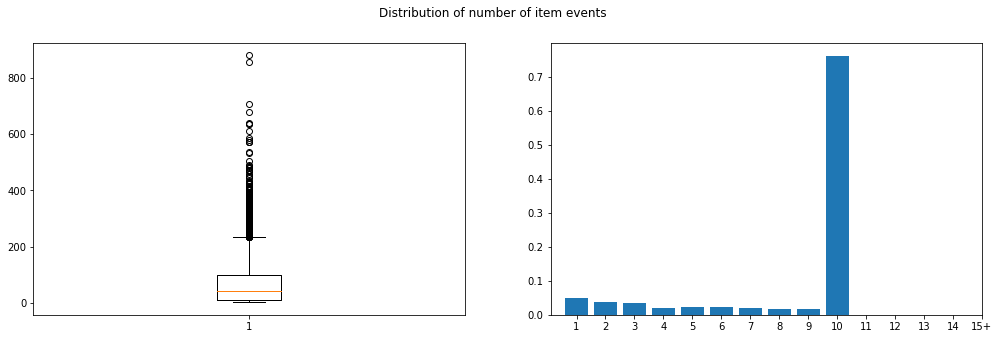

79.59% of items have more than 1 event!


In [40]:
# Distribution of how many a product is slected by different customers
data1 = grouped_cleaned['StockCode'].value_counts()  # count of events per customer
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  # count of counts of events per customer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,16)))
ax2.set_xticklabels(list(range(1,15)) +['15+'])
fig.suptitle("Distribution of number of item events")

plt.show()
print("{0:.2f}% of items have more than 1 event!".format(100 * (np.sum(data1 > 7) / data1.shape[0])))

In [ ]:
# Visualize number of events per day
data = pd.DatetimeIndex(df['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.title('Event frequency time series')
plt.show()

# Reduce Sparsity

> **While implicit recommendations excel where data is sparse, it can often be helpful to make the interactions matrix a little more dense.**

- To reduce sparsity we can exclude users or/and items without significant event history ([cold-start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)))
- We limited our dataset to users and items with at least 5 event occurrences.

In [41]:
def threshold_ratings(grouped_cleaned, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = grouped_cleaned['CustomerID'].nunique()
    n_items = grouped_cleaned['StockCode'].nunique()
    sparsity = (1-float(grouped_cleaned.shape[0]) / float(n_users * n_items)) * 100
    print('Raw dataset info \n-----------------')
    print('Number of customer: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = grouped_cleaned.shape[0]  # number of existing events

        uid_counts = grouped_cleaned.groupby('CustomerID').size()
        grouped_cleaned = grouped_cleaned[~grouped_cleaned['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = grouped_cleaned.groupby('StockCode').size()  # item id frequencies
        grouped_cleaned = grouped_cleaned[~grouped_cleaned['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = grouped_cleaned.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(grouped_cleaned.groupby('CustomerID').size().min() >= uid_min)
        assert(grouped_cleaned.groupby('StockCode').size().min() >= iid_min)
    
    n_users = grouped_cleaned['CustomerID'].nunique()
    n_items = grouped_cleaned['StockCode'].nunique()
    sparsity = (1-float(grouped_cleaned.shape[0]) / float(n_users * n_items)) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of customer: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return grouped_cleaned

In [42]:
# get limited dataset
df_limited = threshold_ratings(grouped_cleaned, 7, 7)

Raw dataset info 
-----------------
Number of customer: 4338
Number of items: 3665
Sparsity: 98.322%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of customer: 3931
Number of items: 2987
Sparsity: 97.757%


df_limited['InvoiceDate'].min()# Train-test split
We want to split the train and test events such that:
- all test events occur after all train events

In [302]:
# Train-test split
start_train = df_limited['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(15, unit='W')
end_test = start_test + pd.to_timedelta(5, unit='W')

# Create new limited df
df_limited = df_limited.loc[(df_limited['InvoiceDate'] > start_train) & (df_limited['InvoiceDate'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.71


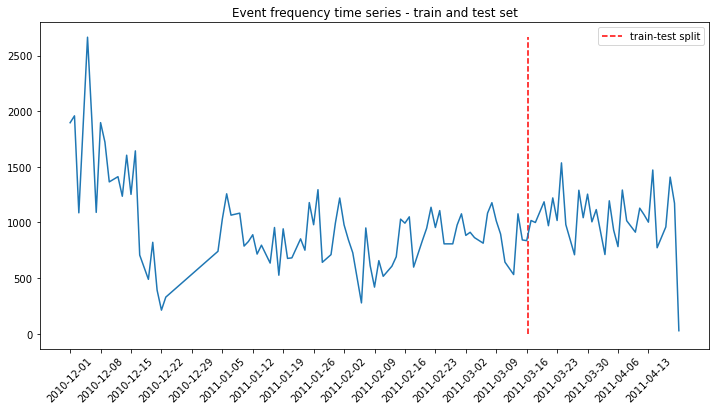

In [303]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

# Create the train and test Rating Matrices

<img src="./images/MaskTrain.png" alt="MaskTrain" style="width: 600px;"/>

In [304]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['StockCode'].astype('category')

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2523, 2217) and test set shape: (2523, 2217)
train set percentage of zeros: 98.83146321322408 and test set percentage of zeros: 99.46657641891262


In [305]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [306]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['StockCode'] == item_id) & (df_limited['train_split'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,train_split
2095,536557,79321,CHILLI LIGHTS,24,2010-12-01 14:41:00,4.25,17841,United Kingdom,False,1
6995,536984,79321,CHILLI LIGHTS,24,2010-12-03 14:35:00,4.25,17841,United Kingdom,False,1
12963,537405,79321,CHILLI LIGHTS,30,2010-12-06 14:51:00,4.25,17841,United Kingdom,False,1
30437,538866,79321,CHILLI LIGHTS,24,2010-12-14 14:40:00,4.25,17841,United Kingdom,False,1
37526,539469,79321,CHILLI LIGHTS,24,2010-12-19 13:59:00,4.25,17841,United Kingdom,False,1
42796,540021,79321,CHILLI LIGHTS,48,2011-01-04 12:51:00,4.25,17841,United Kingdom,False,1
49899,540538,79321,CHILLI LIGHTS,34,2011-01-09 14:36:00,4.25,17841,United Kingdom,False,1
54377,540943,79321,CHILLI LIGHTS,3,2011-01-12 12:31:00,4.95,17841,United Kingdom,False,1
58579,541253,79321,CHILLI LIGHTS,30,2011-01-16 13:51:00,4.25,17841,United Kingdom,False,1
63631,541587,79321,CHILLI LIGHTS,24,2011-01-19 14:39:00,4.25,17841,United Kingdom,False,1


# Fit the ALS model

<img src="./images/Tables.png" alt="Tables" style="width: 1000px;"/>


<img src="./images/ALS_Image_Test.png" alt="MaskTrain" style="width: 600px;"/>


Each (user, item) pair is represented initially through a Ranking matrix, which is used to create a Preference matrix and a Confidence matrix. These give information on whether a user likes an item or not and how confident we are of of the preference values, respectively.

The classical latent factor model is induced by the SVD of the user-item observations matrix that associates each user with a user-factors vector and each item with an item-factors vector. The recommendation score between a user and a item is obtained by taking the inner product between the corresponding user-factors and the item-factors vector. The objective function is based on a least-squares with L2 regularization and this function is minimized using SGD.

The ALS model for implicit feedback data also finds the user-factors and the item-factors vectors by factoring the Preference Matrix. The objective function has two main differences: it accounts for the varying confidence levels (using the Confidence matrix) and it accounts for all possible user/item pairs (note the summation indexes) rather than only those corresponding to observed data (if a user did not consumed a certain item it might be because the user dislikes the item or just because the user did not know about the item). The ALS model objective function is provided below:

<img src="./images/equation.png" alt="MaskTrain" style="width: 600px;"/>

The huge number of terms (m users x n items) in the objective function prevents most direct optimization techniques such as SGD. An alternating-least-squares (ALS) optimization process (ALS) is used instead.



In [307]:
# initialize a model
alpha = 40  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, iterations=30, random_state=0)

# train the model on a sparse matrix of item/user/confidence weights
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

# ALS model methods

In [308]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('22752', 1.0020893),
 ('84029E', 1.0008886),
 ('84029G', 1.0006849),
 ('85123A', 1.0002095),
 ('21071', 0.9999621),
 ('37370', 0.99964726),
 ('22633', 0.999347),
 ('21068', 0.9993466),
 ('22632', 0.99924207),
 ('82483', 0.99865294)]

In [309]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('22633', 1.0000001),
 ('22866', 0.70638573),
 ('22632', 0.6607381),
 ('22865', 0.61632806),
 ('22867', 0.5936794),
 ('82616B', 0.51969546),
 ('85106', 0.51128584),
 ('90199C', 0.5103142),
 ('20894', 0.5095265),
 ('20748', 0.5047788)]

In [311]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the invoice/item pair is: ", score)
print("The top N (itemid, score) contributions for this customer/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the invoice/item pair is:  0.846935246540877
The top N (itemid, score) contributions for this customer/item pair are:
 [('22633', 0.6550101169640477), ('22632', 0.15612529570042402), ('84406B', 0.02017866928217514), ('85123A', 0.014334878355682697), ('84029G', 0.013398541546085524), ('82482', 0.01173369944075624), ('84029E', 0.009195825735043692), ('82483', 0.007839766255451797), ('20679', 0.0068080877884447825), ('21068', 0.00612307229866642)]


# Evaluation
**Note**: We are measuring how well the model will rank the items in the test set for a user, given different items in the training set i.e. **the train and test set have the same users**. We are not making inference for new users that didn't appear in the training set. For new users in production, there is a `recalculate_user` method which can be used for generating recommendations without recalculating the whole model. Also, the `recommend(recalculate_user=True)` method allows the model to recommend for new users on the fly ([github issue](https://github.com/benfred/implicit/issues/152)).

In [312]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [313]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [314]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.098590,0.049748
map,0.048528,0.019717
ndcg,0.110934,0.049449
auc,0.521598,0.508960
